# IMPORTS

In [465]:
import random
import pickle
import glob

import random
import ast
import pathlib

import numpy as np

import matplotlib.pyplot as plt
# import matplotlib.transforms as transforms

from collections import Counter

from time import time
from time import sleep
from time import strftime
from time import localtime
from tqdm import tqdm

from datetime import date, timedelta, datetime

# from mydecorators import logger, stopwatch

from PIL import Image



In [425]:
import torch
import torch.nn as nn
import torchvision

import torch.nn.functional as F

import torchvision.transforms as transforms
from torchvision import datasets

import matplotlib.pyplot as plt

# LOAD IMAGES

In [427]:
# transform = transforms.Compose([
#     transforms.ToTensor()
# ])

# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Grayscale(num_output_channels=1)
# ])


transform = transforms.Compose([
    transforms.Resize((75, 100)),
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1)
])


In [13]:
### loads only perfectmm images & labels them as 'images'
# imagefolder_path = 'saved_lists/perfectmm'

### loads only perfectmm images & labels them as 
### {0: 'nearperfectmm', 1: 'perfectmm', 2: 'streakmm'}
imagefolder_path = 'saved_lists'

# ppath = pathlib.Path(imagefolder_path)

# dataset = datasets.ImageFolder(imagefolder_path)

# dataset = datasets.ImageFolder(imagefolder_path, transform=transforms.ToTensor())


dataset = datasets.ImageFolder(imagefolder_path, transform=transform)

In [14]:
dataset

Dataset ImageFolder
    Number of datapoints: 90000
    Root location: saved_lists
    StandardTransform
Transform: Compose(
               Resize(size=(75, 100), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Grayscale(num_output_channels=1)
           )

In [15]:
type(dataset)

torchvision.datasets.folder.ImageFolder

In [18]:
target_to_class = {v : k for k, v in datasets.ImageFolder(imagefolder_path).class_to_idx.items()}

print(len(target_to_class))
print((target_to_class))

3
{0: 'nearperfectmm', 1: 'perfectmm', 2: 'streakmm'}


In [22]:
# dataloader = torch.utils.data.DataLoader(dataset)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

In [25]:
for images, labels in dataloader:
    break

# images, labels = next(iter(dataloader))

In [27]:
len(dataset)

90000

In [29]:
images[1].shape

torch.Size([1, 75, 100])

In [31]:
images[2]

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.9999, 0.9999, 0.9999,  ..., 0.9999, 0.9999, 0.9999],
         [0.9999, 0.9999, 0.9999,  ..., 0.9999, 0.9999, 0.9999],
         [0.9999, 0.9999, 0.9999,  ..., 0.9999, 0.9999, 0.9999]]])

In [33]:
images.shape

torch.Size([32, 1, 75, 100])

In [35]:
labels[1]

tensor(1)

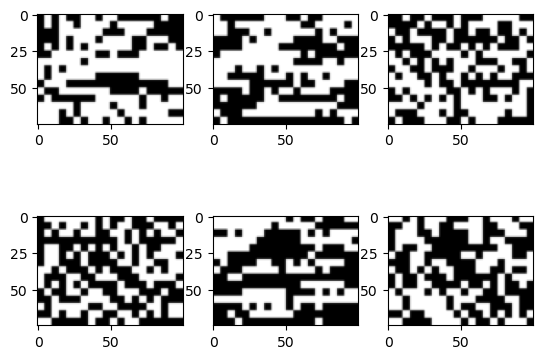

In [37]:
examples = iter(dataloader)
# example_data, example_targets = examples.next()
example_data, example_targets = next(examples)


for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i][0], cmap='gray')
    # print(example_targets)
plt.show()

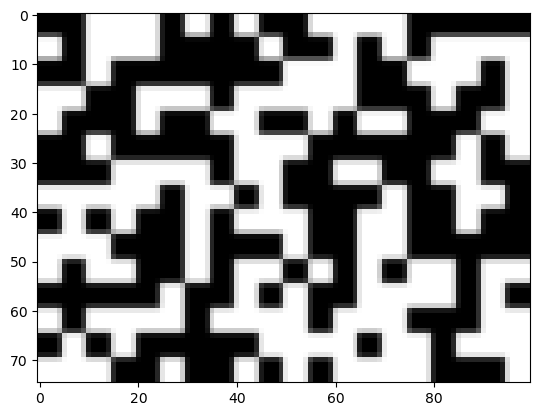

In [39]:
plt.imshow(images[2][0], cmap='gray')

# Split Train & Test (from DATASET)

In [43]:
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [45]:
train_dataset
len(train_dataset)

62999

In [47]:
test_dataset
len(test_dataset)

27001

In [196]:
27001 % 32

25

# Create Train & Test Dataloaders

In [52]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

In [54]:
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

## Check train_dataloader

In [58]:
for images, labels in train_dataloader:
    break

# images, labels = next(iter(dataloader))

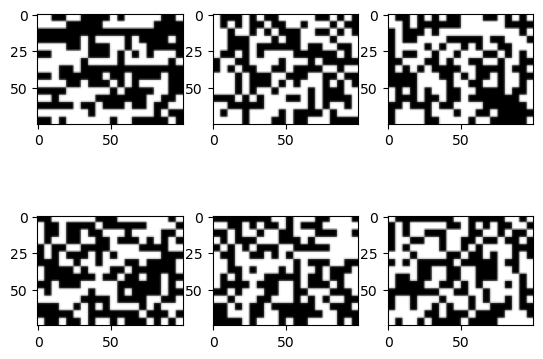

In [60]:
examples = iter(train_dataloader)
# example_data, example_targets = examples.next()
example_data, example_targets = next(examples)


for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i][0], cmap='gray')
    # print(example_targets)
plt.show()

## Check test_dataloader

In [63]:
for images, labels in test_dataloader:
    break

# images, labels = next(iter(dataloader))

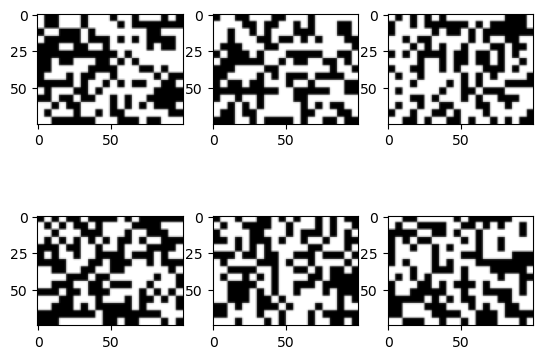

In [65]:
examples = iter(test_dataloader)
# example_data, example_targets = examples.next()
example_data, example_targets = next(examples)


for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i][0], cmap='gray')
    # print(example_targets)
plt.show()

# Create First BASIC MODEL

## First Basic Model Configurations

RuntimeError: shape '[-1, 784]' is invalid for input of size 5178240  

28 * 28 = 784

change to...  
348 * 465 = 161820  
or  
75 * 100 = 7500  

In [71]:
75*100

7500

In [74]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
input_size = 7500 # 75*100
hidden_size = 500
num_classes = 3
num_epochs = 10
# batch_size = 100
learning_rate = 0.001

In [76]:
print(device)

cpu


## Define Model

In [79]:
# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        # no activation and no softmax at the end
        return out

## Train First Basic Model

In [85]:
### Instantiate Model before training
model = NeuralNet(input_size, hidden_size, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
n_total_steps = len(train_dataloader)

for epoch in tqdm(range(num_epochs)):
# for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_dataloader):
        # origin shape: [100, 1, 28, 28]  -> from the code example (mnist)
        # resized: [100, 784] -> from the code example (mnist)
        images = images.reshape(-1, 75*100).to(device)
        labels = labels.to(device)

        # Forward pass and loss calculation
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
            
### 348 * 465 // 66 mins
### 75 * 100 // 21 mins

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Step [100/1969], Loss: 1.1026
Epoch [1/10], Step [200/1969], Loss: 1.1027
Epoch [1/10], Step [300/1969], Loss: 1.0927
Epoch [1/10], Step [400/1969], Loss: 1.0969
Epoch [1/10], Step [500/1969], Loss: 1.1003
Epoch [1/10], Step [600/1969], Loss: 1.0981
Epoch [1/10], Step [700/1969], Loss: 1.0985
Epoch [1/10], Step [800/1969], Loss: 1.0992
Epoch [1/10], Step [900/1969], Loss: 1.0971
Epoch [1/10], Step [1000/1969], Loss: 1.0993
Epoch [1/10], Step [1100/1969], Loss: 1.0990
Epoch [1/10], Step [1200/1969], Loss: 1.0991
Epoch [1/10], Step [1300/1969], Loss: 1.0990
Epoch [1/10], Step [1400/1969], Loss: 1.0988
Epoch [1/10], Step [1500/1969], Loss: 1.1002
Epoch [1/10], Step [1600/1969], Loss: 1.0963
Epoch [1/10], Step [1700/1969], Loss: 1.0989
Epoch [1/10], Step [1800/1969], Loss: 1.0986
Epoch [1/10], Step [1900/1969], Loss: 1.0978


 10%|█         | 1/10 [02:06<18:55, 126.14s/it]

Epoch [2/10], Step [100/1969], Loss: 1.0978
Epoch [2/10], Step [200/1969], Loss: 1.1004
Epoch [2/10], Step [300/1969], Loss: 1.0983
Epoch [2/10], Step [400/1969], Loss: 1.0984
Epoch [2/10], Step [500/1969], Loss: 1.0990
Epoch [2/10], Step [600/1969], Loss: 1.0993
Epoch [2/10], Step [700/1969], Loss: 1.0982
Epoch [2/10], Step [800/1969], Loss: 1.0984
Epoch [2/10], Step [900/1969], Loss: 1.1000
Epoch [2/10], Step [1000/1969], Loss: 1.0980
Epoch [2/10], Step [1100/1969], Loss: 1.0957
Epoch [2/10], Step [1200/1969], Loss: 1.0962
Epoch [2/10], Step [1300/1969], Loss: 1.0945
Epoch [2/10], Step [1400/1969], Loss: 1.0984
Epoch [2/10], Step [1500/1969], Loss: 1.0989
Epoch [2/10], Step [1600/1969], Loss: 1.0975
Epoch [2/10], Step [1700/1969], Loss: 1.0980
Epoch [2/10], Step [1800/1969], Loss: 1.0992
Epoch [2/10], Step [1900/1969], Loss: 1.0998


 20%|██        | 2/10 [04:10<16:41, 125.15s/it]

Epoch [3/10], Step [100/1969], Loss: 1.0987
Epoch [3/10], Step [200/1969], Loss: 1.0985
Epoch [3/10], Step [300/1969], Loss: 1.0991
Epoch [3/10], Step [400/1969], Loss: 1.1011
Epoch [3/10], Step [500/1969], Loss: 1.0990
Epoch [3/10], Step [600/1969], Loss: 1.0986
Epoch [3/10], Step [700/1969], Loss: 1.0983
Epoch [3/10], Step [800/1969], Loss: 1.0987
Epoch [3/10], Step [900/1969], Loss: 1.1007
Epoch [3/10], Step [1000/1969], Loss: 1.0985
Epoch [3/10], Step [1100/1969], Loss: 1.0986
Epoch [3/10], Step [1200/1969], Loss: 1.0968
Epoch [3/10], Step [1300/1969], Loss: 1.0947
Epoch [3/10], Step [1400/1969], Loss: 1.0945
Epoch [3/10], Step [1500/1969], Loss: 1.0988
Epoch [3/10], Step [1600/1969], Loss: 1.0997
Epoch [3/10], Step [1700/1969], Loss: 1.0987
Epoch [3/10], Step [1800/1969], Loss: 1.0974
Epoch [3/10], Step [1900/1969], Loss: 1.0984


 30%|███       | 3/10 [06:14<14:33, 124.75s/it]

Epoch [4/10], Step [100/1969], Loss: 1.0992
Epoch [4/10], Step [200/1969], Loss: 1.1027
Epoch [4/10], Step [300/1969], Loss: 1.0988
Epoch [4/10], Step [400/1969], Loss: 1.0993
Epoch [4/10], Step [500/1969], Loss: 1.1004
Epoch [4/10], Step [600/1969], Loss: 1.0982
Epoch [4/10], Step [700/1969], Loss: 1.0969
Epoch [4/10], Step [800/1969], Loss: 1.1020
Epoch [4/10], Step [900/1969], Loss: 1.0993
Epoch [4/10], Step [1000/1969], Loss: 1.0976
Epoch [4/10], Step [1100/1969], Loss: 1.0986
Epoch [4/10], Step [1200/1969], Loss: 1.0981
Epoch [4/10], Step [1300/1969], Loss: 1.1027
Epoch [4/10], Step [1400/1969], Loss: 1.0988
Epoch [4/10], Step [1500/1969], Loss: 1.0989
Epoch [4/10], Step [1600/1969], Loss: 1.0991
Epoch [4/10], Step [1700/1969], Loss: 1.0994
Epoch [4/10], Step [1800/1969], Loss: 1.0999
Epoch [4/10], Step [1900/1969], Loss: 1.1022


 40%|████      | 4/10 [08:16<12:21, 123.66s/it]

Epoch [5/10], Step [100/1969], Loss: 1.0981
Epoch [5/10], Step [200/1969], Loss: 1.0981
Epoch [5/10], Step [300/1969], Loss: 1.0987
Epoch [5/10], Step [400/1969], Loss: 1.0988
Epoch [5/10], Step [500/1969], Loss: 1.0983
Epoch [5/10], Step [600/1969], Loss: 1.0995
Epoch [5/10], Step [700/1969], Loss: 1.0972
Epoch [5/10], Step [800/1969], Loss: 1.0987
Epoch [5/10], Step [900/1969], Loss: 1.0978
Epoch [5/10], Step [1000/1969], Loss: 1.0951
Epoch [5/10], Step [1100/1969], Loss: 1.0983
Epoch [5/10], Step [1200/1969], Loss: 1.0983
Epoch [5/10], Step [1300/1969], Loss: 1.0987
Epoch [5/10], Step [1400/1969], Loss: 1.0986
Epoch [5/10], Step [1500/1969], Loss: 1.0987
Epoch [5/10], Step [1600/1969], Loss: 1.0984
Epoch [5/10], Step [1700/1969], Loss: 1.1004
Epoch [5/10], Step [1800/1969], Loss: 1.1000
Epoch [5/10], Step [1900/1969], Loss: 1.0990


 50%|█████     | 5/10 [10:18<10:15, 123.04s/it]

Epoch [6/10], Step [100/1969], Loss: 1.0973
Epoch [6/10], Step [200/1969], Loss: 1.0995
Epoch [6/10], Step [300/1969], Loss: 1.1016
Epoch [6/10], Step [400/1969], Loss: 1.0999
Epoch [6/10], Step [500/1969], Loss: 1.0983
Epoch [6/10], Step [600/1969], Loss: 1.0991
Epoch [6/10], Step [700/1969], Loss: 1.0982
Epoch [6/10], Step [800/1969], Loss: 1.0989
Epoch [6/10], Step [900/1969], Loss: 1.0983
Epoch [6/10], Step [1000/1969], Loss: 1.0986
Epoch [6/10], Step [1100/1969], Loss: 1.0997
Epoch [6/10], Step [1200/1969], Loss: 1.0970
Epoch [6/10], Step [1300/1969], Loss: 1.0989
Epoch [6/10], Step [1400/1969], Loss: 1.0970
Epoch [6/10], Step [1500/1969], Loss: 1.0964
Epoch [6/10], Step [1600/1969], Loss: 1.0973
Epoch [6/10], Step [1700/1969], Loss: 1.0979
Epoch [6/10], Step [1800/1969], Loss: 1.0975
Epoch [6/10], Step [1900/1969], Loss: 1.0980


 60%|██████    | 6/10 [12:20<08:10, 122.65s/it]

Epoch [7/10], Step [100/1969], Loss: 1.0988
Epoch [7/10], Step [200/1969], Loss: 1.1015
Epoch [7/10], Step [300/1969], Loss: 1.0997
Epoch [7/10], Step [400/1969], Loss: 1.0986
Epoch [7/10], Step [500/1969], Loss: 1.0994
Epoch [7/10], Step [600/1969], Loss: 1.0985
Epoch [7/10], Step [700/1969], Loss: 1.0987
Epoch [7/10], Step [800/1969], Loss: 1.0937
Epoch [7/10], Step [900/1969], Loss: 1.1015
Epoch [7/10], Step [1000/1969], Loss: 1.0987
Epoch [7/10], Step [1100/1969], Loss: 1.0984
Epoch [7/10], Step [1200/1969], Loss: 1.0993
Epoch [7/10], Step [1300/1969], Loss: 1.0984
Epoch [7/10], Step [1400/1969], Loss: 1.0978
Epoch [7/10], Step [1500/1969], Loss: 1.0984
Epoch [7/10], Step [1600/1969], Loss: 1.0974
Epoch [7/10], Step [1700/1969], Loss: 1.0977
Epoch [7/10], Step [1800/1969], Loss: 1.0988
Epoch [7/10], Step [1900/1969], Loss: 1.0983


 70%|███████   | 7/10 [14:21<06:06, 122.14s/it]

Epoch [8/10], Step [100/1969], Loss: 1.1038
Epoch [8/10], Step [200/1969], Loss: 1.1062
Epoch [8/10], Step [300/1969], Loss: 1.0977
Epoch [8/10], Step [400/1969], Loss: 1.1005
Epoch [8/10], Step [500/1969], Loss: 1.0981
Epoch [8/10], Step [600/1969], Loss: 1.0990
Epoch [8/10], Step [700/1969], Loss: 1.0989
Epoch [8/10], Step [800/1969], Loss: 1.0996
Epoch [8/10], Step [900/1969], Loss: 1.1020
Epoch [8/10], Step [1000/1969], Loss: 1.0981
Epoch [8/10], Step [1100/1969], Loss: 1.0985
Epoch [8/10], Step [1200/1969], Loss: 1.0983
Epoch [8/10], Step [1300/1969], Loss: 1.1036
Epoch [8/10], Step [1400/1969], Loss: 1.0994
Epoch [8/10], Step [1500/1969], Loss: 1.1001
Epoch [8/10], Step [1600/1969], Loss: 1.1018
Epoch [8/10], Step [1700/1969], Loss: 1.1001
Epoch [8/10], Step [1800/1969], Loss: 1.1003
Epoch [8/10], Step [1900/1969], Loss: 1.0995


 80%|████████  | 8/10 [16:22<04:03, 121.60s/it]

Epoch [9/10], Step [100/1969], Loss: 1.0983
Epoch [9/10], Step [200/1969], Loss: 1.0971
Epoch [9/10], Step [300/1969], Loss: 1.0990
Epoch [9/10], Step [400/1969], Loss: 1.0984
Epoch [9/10], Step [500/1969], Loss: 1.0999
Epoch [9/10], Step [600/1969], Loss: 1.0975
Epoch [9/10], Step [700/1969], Loss: 1.1022
Epoch [9/10], Step [800/1969], Loss: 1.0977
Epoch [9/10], Step [900/1969], Loss: 1.0968
Epoch [9/10], Step [1000/1969], Loss: 1.0980
Epoch [9/10], Step [1100/1969], Loss: 1.0952
Epoch [9/10], Step [1200/1969], Loss: 1.0974
Epoch [9/10], Step [1300/1969], Loss: 1.0985
Epoch [9/10], Step [1400/1969], Loss: 1.0972
Epoch [9/10], Step [1500/1969], Loss: 1.0997
Epoch [9/10], Step [1600/1969], Loss: 1.0986
Epoch [9/10], Step [1700/1969], Loss: 1.0994
Epoch [9/10], Step [1800/1969], Loss: 1.0990
Epoch [9/10], Step [1900/1969], Loss: 1.0979


 90%|█████████ | 9/10 [18:22<02:01, 121.30s/it]

Epoch [10/10], Step [100/1969], Loss: 1.0990
Epoch [10/10], Step [200/1969], Loss: 1.0982
Epoch [10/10], Step [300/1969], Loss: 1.0983
Epoch [10/10], Step [400/1969], Loss: 1.0990
Epoch [10/10], Step [500/1969], Loss: 1.0986
Epoch [10/10], Step [600/1969], Loss: 1.0968
Epoch [10/10], Step [700/1969], Loss: 1.1005
Epoch [10/10], Step [800/1969], Loss: 1.0998
Epoch [10/10], Step [900/1969], Loss: 1.0981
Epoch [10/10], Step [1000/1969], Loss: 1.0986
Epoch [10/10], Step [1100/1969], Loss: 1.0997
Epoch [10/10], Step [1200/1969], Loss: 1.0980
Epoch [10/10], Step [1300/1969], Loss: 1.0969
Epoch [10/10], Step [1400/1969], Loss: 1.1009
Epoch [10/10], Step [1500/1969], Loss: 1.0991
Epoch [10/10], Step [1600/1969], Loss: 1.1004
Epoch [10/10], Step [1700/1969], Loss: 1.0977
Epoch [10/10], Step [1800/1969], Loss: 1.0983
Epoch [10/10], Step [1900/1969], Loss: 1.0992


100%|██████████| 10/10 [20:23<00:00, 122.38s/it]


## Test First Basic Model

In [92]:
# Test the model: we don't need to compute gradients
with torch.no_grad():
    n_correct = 0
    n_samples = len(test_dataloader.dataset)

    for images, labels in test_dataloader:
        images = images.reshape(-1, 75*100).to(device)
        labels = labels.to(device)

        outputs = model(images)

        # max returns (output_value ,index)
        _, predicted = torch.max(outputs, 1)
        n_correct += (predicted == labels).sum().item()

    acc = n_correct / n_samples
    print(f'Accuracy of the network on the {n_samples} test images: {100*acc} %')
    
### Accuracy of the network on the 27001 test images: 41.26884189474464 % (348 * 465 // 66 mins to train)
### Accuracy of the network on the 27001 test images: 33.07655272026962 % (75 * 100 // 20 mins to train)

Accuracy of the network on the 27001 test images: 33.07655272026962 %


### Test Individual Sample(s)

In [95]:
print(labels)

tensor([1, 1, 0, 2, 0, 0, 0, 2, 1, 1, 1, 2, 1, 2, 2, 0, 2, 2, 0, 1, 0, 1, 0, 2,
        1])


In [101]:
pred = model(images[0].reshape(-1, 75*100))
print(pred)

tensor([[ 0.0001, -0.0036,  0.0094]], grad_fn=<AddmmBackward0>)


In [111]:
display(images[0])

tensor([0.0000, 0.0000, 0.0000,  ..., 0.9999, 0.9999, 0.9999])

## Save First Basic Model

In [141]:
PATH = './models/practice/first_basic_model.pth'
torch.save(model.state_dict(), PATH)

## Load First Basic Model

In [143]:
loaded_model = NeuralNet(input_size, hidden_size, num_classes).to(device)
loaded_model.load_state_dict(torch.load(PATH)) # it takes the loaded dictionary, not the path file itself
loaded_model.to(device)
loaded_model.eval()

NeuralNet(
  (l1): Linear(in_features=7500, out_features=500, bias=True)
  (relu): ReLU()
  (l2): Linear(in_features=500, out_features=3, bias=True)
)

In [148]:
# Test the loaded_model: we don't need to compute gradients
with torch.no_grad():
    n_correct = 0
    n_samples = len(test_dataloader.dataset)

    for images, labels in test_dataloader:
        images = images.reshape(-1, 75*100).to(device)
        labels = labels.to(device)

        outputs = loaded_model(images)

        # max returns (output_value ,index)
        _, predicted = torch.max(outputs, 1)
        n_correct += (predicted == labels).sum().item()

    acc = n_correct / n_samples
    print(f'Accuracy of the network on the {n_samples} test images: {100*acc} %')
    
### Accuracy of the network on the 27001 test images: 41.26884189474464 %
### Accuracy of the network on the 27001 test images: 33.07655272026962 %

Accuracy of the network on the 27001 test images: 33.07655272026962 %


# Create First CNN
PerfectMM vs NearPerfectMM vs StreakMM

## First CNN Configurations

In [172]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
input_size = 75*100 # 348x465
# hidden_size = 500
num_classes = 3
num_epochs = 10
# batch_size = 100
learning_rate = 0.001

## Define Model

In [157]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 64, 3)
        self.fc1 = nn.Linear(64*15*21, 64)
        self.fc2 = nn.Linear(64, 3)

    def forward(self, x):
        # batch_size, 1, 75, 100
        # print(x.shape)
        x = F.relu(self.conv1(x))   # -> batch_size, 32, 73, 98
        # print(x.shape)
        x = self.pool(x)            # -> batch_size, 32, 36, 49
        # print(x.shape)
        x = F.relu(self.conv2(x))   # -> batch_size, 64, 34, 47
        # print(x.shape)
        x = self.pool(x)            # -> batch_size, 64, 17, 23
        # print(x.shape)
        x = F.relu(self.conv3(x))   # -> batch_size, 64, 15, 21
        # print(x.shape)
        x = torch.flatten(x, 1)     # -> batch_size, 20160
        # print(x.shape)
        x = F.relu(self.fc1(x))     # -> batch_size, 64
        # print(x.shape)
        x = self.fc2(x)             # -> batch_size, 3
        # print(x.shape)
        return x

In [161]:
# 64*15*21

## Train First CNN Model

In [175]:
model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

n_total_steps = len(train_dataloader)
for epoch in tqdm(range(num_epochs)):

    running_loss = 0.0

    for i, (images, labels) in enumerate(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        running_loss += loss.item()

    print(f'[{epoch + 1}] loss: {running_loss / n_total_steps:.3f}')

print('Finished Training')
PATH = './models/practice/cnn_10epo.pth'
torch.save(model.state_dict(), PATH)

### 4.5 mins per epoch to train

 10%|█         | 1/10 [04:32<40:50, 272.31s/it]

[1] loss: 0.499


 20%|██        | 2/10 [09:05<36:22, 272.80s/it]

[2] loss: 0.466


 30%|███       | 3/10 [13:38<31:49, 272.82s/it]

[3] loss: 0.465


 40%|████      | 4/10 [18:10<27:15, 272.52s/it]

[4] loss: 0.462


 50%|█████     | 5/10 [22:41<22:39, 271.95s/it]

[5] loss: 0.462


 60%|██████    | 6/10 [27:12<18:06, 271.53s/it]

[6] loss: 0.457


 70%|███████   | 7/10 [31:42<13:34, 271.35s/it]

[7] loss: 0.451


 80%|████████  | 8/10 [36:14<09:02, 271.45s/it]

[8] loss: 0.437


 90%|█████████ | 9/10 [40:46<04:31, 271.62s/it]

[9] loss: 0.415


100%|██████████| 10/10 [45:17<00:00, 271.75s/it]

[10] loss: 0.382
Finished Training


## Test First CNN Model

In [183]:
PATH = './models/practice/cnn_10epo.pth'

In [184]:
loaded_model = ConvNet()
loaded_model.load_state_dict(torch.load(PATH)) # it takes the loaded dictionary, not the path file itself
loaded_model.to(device)
loaded_model.eval()

with torch.no_grad():
    n_correct = 0
    n_correct2 = 0
    n_samples = len(test_dataloader.dataset)

    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)

        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_correct += (predicted == labels).sum().item()

        outputs2 = loaded_model(images)
        _, predicted2 = torch.max(outputs2, 1)
        n_correct2 += (predicted2 == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the model: {acc} %')

    acc = 100.0 * n_correct2 / n_samples
    print(f'Accuracy of the loaded model: {acc} %')
    
### Accuracy of the model: 66.59012629161883 %
### Accuracy of the loaded model: 66.59012629161883 %

Accuracy of the model: 66.59012629161883 %
Accuracy of the loaded model: 66.59012629161883 %


In [192]:
print(images.shape)

torch.Size([25, 1, 75, 100])


In [253]:
start = time()
print(strftime('%Y-%m-%d %H:%M:%S', localtime()))
print('\n')
##############################################################################################################################



loaded_model = ConvNet()
loaded_model.load_state_dict(torch.load(PATH)) # it takes the loaded dictionary, not the path file itself
loaded_model.to(device)
loaded_model.eval()

# wrong_answers = []
all_answers = []

with torch.no_grad():
    n_correct = 0
    n_correct2 = 0
    n_samples = len(test_dataloader.dataset)

    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)

        # max returns (value ,index)
        outputs2 = loaded_model(images)
        _, predicted2 = torch.max(outputs2, 1)
        
        n_correct2 += (predicted2 == labels).sum().item()
        
        
        labels_list = labels.tolist()
        predicted2_list = predicted2.tolist()
        
        for i in range(len(labels_list)):
            # if predicted2_list[i] != labels_list[i]:
                # wrong_answers.append([labels_list[i], predicted2_list[i]])
                all_answers.append((labels_list[i], predicted2_list[i]))
                
    acc = 100.0 * n_correct2 / n_samples
    print(f'Accuracy of the loaded model: {acc} %')
    

##############################################################################################################################
print('\n----------------------------------------------------')
print("done in %0.3fs." % (time() - start))
print(strftime('%Y-%m-%d %H:%M:%S', localtime()))
    


    
### Accuracy of the model: 66.59012629161883 %
### Accuracy of the loaded model: 66.59012629161883 %

2024-05-09 14:33:44


Accuracy of the loaded model: 66.59012629161883 %

----------------------------------------------------
done in 93.863s.
2024-05-09 14:35:18


In [257]:
# print(len(wrong_answers))
print(len(all_answers))
print(type(all_answers))


27001
<class 'list'>


In [273]:
# Counter(all_answers)
dict(Counter(all_answers))

{(1, 1): 4364,
 (0, 1): 4320,
 (0, 0): 4697,
 (1, 0): 4687,
 (2, 2): 8919,
 (2, 0): 6,
 (2, 1): 6,
 (1, 2): 2}

In [243]:
# for item in all_answers:
#     print(item)

In [288]:
images[0].shape

torch.Size([1, 75, 100])

### Test Individual Sample(s)

In [311]:
loaded_model

ConvNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=20160, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=3, bias=True)
)

In [363]:
labels

tensor([1, 1, 0, 2, 0, 0, 0, 2, 1, 1, 1, 2, 1, 2, 2, 0, 2, 2, 0, 1, 0, 1, 0, 2,
        1])

In [325]:
images[0].shape

torch.Size([1, 75, 100])

In [361]:
pred = loaded_model(images[0][None,:])

_, pred = torch.max(pred, 1) 

print(pred)

tensor([0])


### Open one image from LIVE_DATA

In [519]:
# one_image = torchvision.io.read_image('images/live_data/silver_zello.txt.png')
# one_image = torchvision.io.read_image('images/nearperfectmm/nearperfectmm_1000_image_844.png')

# one_image = Image.open('images/live_data/silver_zello.txt.png')
one_image = Image.open('images/live_data/silver_sensejange.txt.png').convert('RGB')

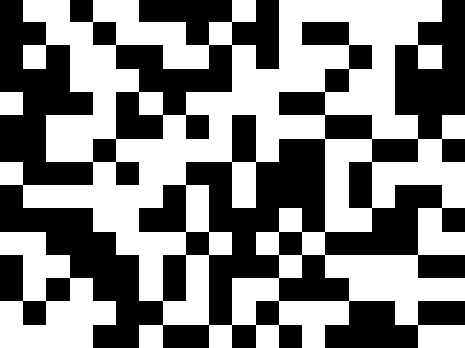

In [521]:
one_image

In [523]:
# one_image.numpy().shape

In [525]:
type(one_image)

PIL.Image.Image

In [528]:
# one_image = transform(one_image)
one_image = transform(one_image)

In [530]:
one_image.shape

torch.Size([1, 75, 100])

In [532]:
one_image = one_image[None, :]
one_image.shape

torch.Size([1, 1, 75, 100])

In [535]:
pred = loaded_model(one_image)

_, pred = torch.max(pred, 1) 

print(pred)

tensor([1])


# LOAD IMAGES from FOUR CLASSES

In [573]:
### loads only perfectmm images & labels them as 'images'
# imagefolder_path = 'saved_lists/perfectmm'

### loads only perfectmm images & labels them as 
### {0: 'nearperfectmm', 1: 'perfectmm', 2: 'streakmm'}
imagefolder_path = 'images'

# ppath = pathlib.Path(imagefolder_path)

# dataset = datasets.ImageFolder(imagefolder_path)

# dataset = datasets.ImageFolder(imagefolder_path, transform=transforms.ToTensor())


all_dataset = datasets.ImageFolder(imagefolder_path, transform=transform)

In [575]:
all_dataset

Dataset ImageFolder
    Number of datapoints: 131603
    Root location: images
    StandardTransform
Transform: Compose(
               Resize(size=(75, 100), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Grayscale(num_output_channels=1)
           )

In [624]:
target_to_class = {v : k for k, v in datasets.ImageFolder(imagefolder_path).class_to_idx.items()}

print(len(target_to_class))
print((target_to_class))

4
{0: 'live_data', 1: 'nearperfectmm', 2: 'perfectmm', 3: 'streakmm'}


## Split Train & Test (all_dataset)

In [578]:
train_size = int(0.7 * len(all_dataset))
test_size = len(all_dataset) - train_size
train_alldataset, test_alldataset = torch.utils.data.random_split(all_dataset, [train_size, test_size])

In [583]:
train_alldataset
len(train_alldataset)

92122

In [585]:
test_alldataset
len(test_alldataset)

39481

## Create Train & Test all_dataloaders

In [592]:
train_alldataloader = torch.utils.data.DataLoader(train_alldataset, batch_size=32, shuffle=True)

In [594]:
test_alldataloader = torch.utils.data.DataLoader(test_alldataset, batch_size=32, shuffle=False)

### Check Train alldataloader

In [597]:
for images, labels in train_alldataloader:
    break

# images, labels = next(iter(dataloader))

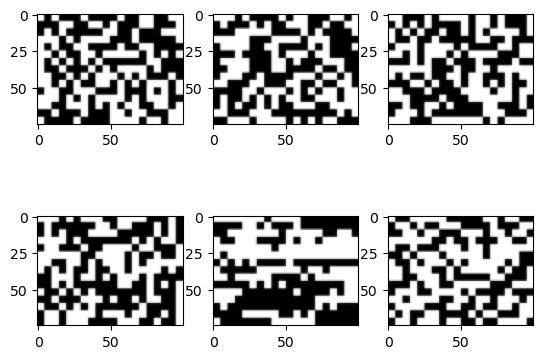

In [599]:
examples = iter(train_alldataloader)
# example_data, example_targets = examples.next()
example_data, example_targets = next(examples)


for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i][0], cmap='gray')
    # print(example_targets)
plt.show()

### Check Test alldataloader

In [602]:
for images, labels in test_alldataloader:
    break

# images, labels = next(iter(dataloader))

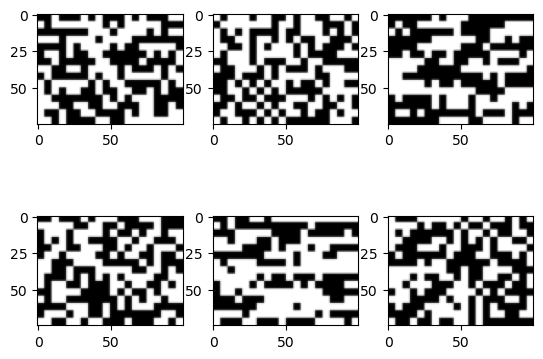

In [604]:
examples = iter(test_alldataloader)
# example_data, example_targets = examples.next()
example_data, example_targets = next(examples)


for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i][0], cmap='gray')
    # print(example_targets)
plt.show()

# Create First CNN for all CLASSES
PerfectMM vs NearPerfectMM vs StreakMM vs Live Data


## CNN for ALL Configurations

In [696]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
input_size = 75*100 # originally 348x465 without resize
# hidden_size = 500
num_classes = 4
num_epochs = 20
# num_epochs = 2
# batch_size = 100
learning_rate = 0.001

## Define Model

In [699]:
### same as FIRST CNN

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 64, 3)
        self.fc1 = nn.Linear(64*15*21, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        # batch_size, 1, 75, 100
        # print(x.shape)
        x = F.relu(self.conv1(x))   # -> batch_size, 32, 73, 98
        # print(x.shape)
        x = self.pool(x)            # -> batch_size, 32, 36, 49
        # print(x.shape)
        x = F.relu(self.conv2(x))   # -> batch_size, 64, 34, 47
        # print(x.shape)
        x = self.pool(x)            # -> batch_size, 64, 17, 23
        # print(x.shape)
        x = F.relu(self.conv3(x))   # -> batch_size, 64, 15, 21
        # print(x.shape)
        x = torch.flatten(x, 1)     # -> batch_size, 20160
        # print(x.shape)
        x = F.relu(self.fc1(x))     # -> batch_size, 64
        # print(x.shape)
        x = self.fc2(x)             # -> batch_size, num_classes(=4)
        # print(x.shape)
        return x

## Train CNN for ALL CLASSES

In [703]:
start = time()
print(strftime('%Y-%m-%d %H:%M:%S', localtime()))
print('\n')
##############################################################################################################################

model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

n_total_steps = len(train_alldataloader)
for epoch in tqdm(range(num_epochs)):

    running_loss = 0.0

    for i, (images, labels) in enumerate(train_alldataloader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        running_loss += loss.item()

    print(f'[{epoch + 1}] loss: {running_loss / n_total_steps:.3f}')

print('Finished Training')
PATH = './models/practice/cnn_allclasses_v1.1_20epo.pth'
torch.save(model.state_dict(), PATH)

##############################################################################################################################
print('\n----------------------------------------------------')
print("done in %0.3fs." % (time() - start))
print(strftime('%Y-%m-%d %H:%M:%S', localtime()))




### 6.5 mins per epoch to train
### 

2024-05-10 12:04:27




  5%|▌         | 1/20 [06:40<2:06:57, 400.90s/it]

[1] loss: 0.852


 10%|█         | 2/20 [13:24<2:00:40, 402.27s/it]

[2] loss: 0.830


 15%|█▌        | 3/20 [20:10<1:54:26, 403.92s/it]

[3] loss: 0.824


 20%|██        | 4/20 [26:56<1:48:00, 405.03s/it]

[4] loss: 0.818


 25%|██▌       | 5/20 [33:43<1:41:24, 405.63s/it]

[5] loss: 0.809


 30%|███       | 6/20 [40:26<1:34:26, 404.73s/it]

[6] loss: 0.796


 35%|███▌      | 7/20 [47:10<1:27:40, 404.62s/it]

[7] loss: 0.776


 40%|████      | 8/20 [53:54<1:20:50, 404.21s/it]

[8] loss: 0.747


 45%|████▌     | 9/20 [1:00:34<1:13:52, 402.98s/it]

[9] loss: 0.709


 50%|█████     | 10/20 [1:07:12<1:06:55, 401.59s/it]

[10] loss: 0.673


 55%|█████▌    | 11/20 [1:13:52<1:00:08, 400.97s/it]

[11] loss: 0.639


 60%|██████    | 12/20 [1:20:34<53:30, 401.35s/it]  

[12] loss: 0.610


 65%|██████▌   | 13/20 [1:27:16<46:49, 401.43s/it]

[13] loss: 0.583


 70%|███████   | 14/20 [1:34:02<40:16, 402.81s/it]

[14] loss: 0.563


 75%|███████▌  | 15/20 [1:40:47<33:37, 403.54s/it]

[15] loss: 0.542


 80%|████████  | 16/20 [1:47:30<26:53, 403.25s/it]

[16] loss: 0.527


 85%|████████▌ | 17/20 [1:54:10<20:07, 402.43s/it]

[17] loss: 0.510


 90%|█████████ | 18/20 [2:00:50<13:23, 401.71s/it]

[18] loss: 0.494


 95%|█████████▌| 19/20 [2:07:32<06:41, 401.72s/it]

[19] loss: 0.480


100%|██████████| 20/20 [2:14:18<00:00, 402.91s/it]

[20] loss: 0.467
Finished Training

----------------------------------------------------
done in 8058.282s.
2024-05-10 14:18:46


## Test CNN for ALL CLASSES

In [726]:
PATH = './models/practice/cnn_allclasses_v1.1_20epo.pth'
print(PATH)

./models/practice/cnn_allclasses_v1.1_20epo.pth


In [729]:
start = time()
print(strftime('%Y-%m-%d %H:%M:%S', localtime()))
print('\n')
##############################################################################################################################



loaded_model = ConvNet()
loaded_model.load_state_dict(torch.load(PATH)) # it takes the loaded dictionary, not the path file itself
loaded_model.to(device)
loaded_model.eval()

# wrong_answers = []
all_answers = []

with torch.no_grad():
    n_correct = 0
    n_correct2 = 0
    n_samples = len(test_alldataloader.dataset)

    for images, labels in test_alldataloader:
        images = images.to(device)
        labels = labels.to(device)
        # outputs = model(images)

        # max returns (value ,index)
        outputs2 = loaded_model(images)
        _, predicted2 = torch.max(outputs2, 1)
        
        n_correct2 += (predicted2 == labels).sum().item()
        
        
        labels_list = labels.tolist()
        predicted2_list = predicted2.tolist()
        
        for i in range(len(labels_list)):
            # if predicted2_list[i] != labels_list[i]:
                # wrong_answers.append([labels_list[i], predicted2_list[i]])
                all_answers.append((labels_list[i], predicted2_list[i]))
                
    acc = 100.0 * n_correct2 / n_samples
    print(f'Accuracy of the loaded model: {acc} %')
    

##############################################################################################################################
print('\n----------------------------------------------------')
print("done in %0.3fs." % (time() - start))
print(strftime('%Y-%m-%d %H:%M:%S', localtime()))
    
### ~160s

    
### Accuracy of the loaded model: 22.276538081608876 % (when incorrect number of outputs were used 
### & wrong dataloader(train_dataloader, not train_alldataloader) used) => cnn_allclasses_10epo.pth
### 

### Accuracy of the loaded model: 54.98087687748537 % (when correct number of outputs were used with right data / 2 epo)
### Accuracy of the loaded model: 50.758592740812034 % (10 epochs)
### Accuracy of the loaded model: 50.87763734454548 % (20 epochs)

2024-05-10 16:49:04


Accuracy of the loaded model: 50.87763734454548 %

----------------------------------------------------
done in 107.091s.
2024-05-10 16:50:51


In [730]:
# print(len(wrong_answers))
print(len(all_answers))
print(type(all_answers))


39481
<class 'list'>


In [731]:
labels

tensor([2, 1, 3, 0, 3, 1, 1, 2, 0, 0, 2, 1, 2, 1, 0, 2, 0, 0, 0, 0, 0, 2, 0, 1,
        0])

In [732]:
# Counter(all_answers)
dict(Counter(all_answers))


### {0: 'live_data', 1: 'nearperfectmm', 2: 'perfectmm', 3: 'streakmm'}

### when incorrect number of outputs(=3) were used & wrong dataloader used
# {(1, 1): 1772,
# (0, 0): 7022,
# (3, 2): 8960,
# (1, 0): 7173,
# (2, 1): 6156,
# (2, 0): 2966,
# (0, 1): 5415,
# (0, 2): 11,
# (1, 2): 1,
# (2, 2): 1,
# (3, 0): 3,
# (3, 1): 1}

### when correct number of outputs(=4) were used with the right dataloader (2epo)
# {(1, 0): 8287,
# (0, 0): 12105,
# (3, 3): 8962,
# (2, 0): 8490,
# (1, 1): 200,
# (0, 2): 237,
# (2, 2): 440,
# (1, 2): 455,
# (0, 1): 91,
# (2, 1): 190,
# (1, 3): 4,
# (3, 0): 2,
# (0, 3): 15,
# (2, 3): 3}

{(1, 0): 3080,
 (0, 2): 3954,
 (3, 3): 8941,
 (1, 1): 2743,
 (2, 0): 3194,
 (0, 0): 5224,
 (2, 2): 3179,
 (2, 1): 2741,
 (1, 2): 3110,
 (0, 1): 3228,
 (2, 3): 9,
 (0, 3): 42,
 (3, 0): 21,
 (1, 3): 13,
 (3, 2): 2}

# RANDOM EXPERIMENTS

In [347]:
a = torch.randn(4, 4)



In [349]:
a

tensor([[-0.6304, -0.3617,  0.9285, -0.1823],
        [-0.0157,  0.8510,  1.0470, -1.8385],
        [ 0.8468, -0.0282,  0.1650, -1.1636],
        [ 1.4060,  0.2763,  1.5787,  0.3472]])

In [351]:
a.shape

torch.Size([4, 4])

In [353]:
a = a[None, :]
a

tensor([[[-0.6304, -0.3617,  0.9285, -0.1823],
         [-0.0157,  0.8510,  1.0470, -1.8385],
         [ 0.8468, -0.0282,  0.1650, -1.1636],
         [ 1.4060,  0.2763,  1.5787,  0.3472]]])

In [355]:
a.shape

torch.Size([1, 4, 4])

In [327]:
b = torch.Tensor([1])
b

tensor([1.])

In [130]:
torch.max(a, 0)

torch.return_types.max(
values=tensor([ 2.2638,  0.6155, -0.0930,  0.7809]),
indices=tensor([0, 1, 0, 0]))

In [132]:
torch.max(a, 1)

torch.return_types.max(
values=tensor([ 2.2638,  0.6155, -0.0930,  0.7809]),
indices=tensor([0, 1, 0, 0]))

In [134]:

torch.max(a, -1)


torch.return_types.max(
values=tensor([ 2.2638,  0.6155, -0.0930,  0.7809]),
indices=tensor([0, 1, 0, 0]))

In [136]:

torch.max(a, -2)


torch.return_types.max(
values=tensor([2.2638, 0.6155, 0.1529, 1.0407]),
indices=tensor([0, 1, 3, 0]))

In [222]:
llist = labels.tolist()
print(llist)

[1, 1, 0, 2, 0, 0, 0, 2, 1, 1, 1, 2, 1, 2, 2, 0, 2, 2, 0, 1, 0, 1, 0, 2, 1]


In [226]:
torch.Tensor(llist)

tensor([1., 1., 0., 2., 0., 0., 0., 2., 1., 1., 1., 2., 1., 2., 2., 0., 2., 2.,
        0., 1., 0., 1., 0., 2., 1.])

In [228]:
labels

tensor([1, 1, 0, 2, 0, 0, 0, 2, 1, 1, 1, 2, 1, 2, 2, 0, 2, 2, 0, 1, 0, 1, 0, 2,
        1])

In [230]:
labels == torch.Tensor(llist)

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True])

In [ ]:
transform = transforms.Compose([
    transforms.Resize((75, 100)),
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1)
])

img

In [ ]:
H, W = 32, 32
img = torch.randint(0, 256, size=(3, H, W), dtype=torch.uint8)


transform = transforms.Compose([
    transforms.Resize((75, 100)),
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1)
])

img = transform(img)

TypeError: pic should be PIL Image or ndarray. Got <class 'torch.Tensor'>